### Extract a Shell Mass Region  

In [1]:
%matplotlib inline
import shell_model
import astropy.units as u
from astropy.coordinates import SkyCoord
import shells
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import Angle, SkyCoord
from regions import PixCoord, CircleSkyRegion, CirclePixelRegion
from spectral_cube import SpectralCube
dist = 414*u.pc

In [2]:
# BEST-FIT PARAMETERS FOR SHELL 18
r = 0.17 * u.pc
dr = 0.25 * u.pc
vexp = 4 * u.km/u.s
v0 = 14.25 * u.km/u.s
shell_center = SkyCoord("5h34m54.496s","-5d04m40.05s")
ra, dec = shell_center.ra, shell_center.dec
r_angle = (r / dist) * u.radian
dr_angle = (dr / dist) * u.radian

100611129.93136448 K km / s


(82, 40, 39)

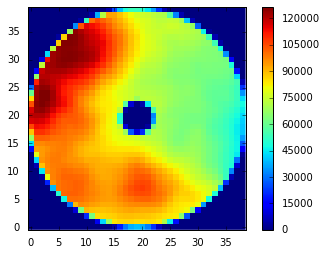

In [3]:
cube = SpectralCube.read(
    "../nro_maps/12CO_20161002_FOREST-BEARS_spheroidal_xyb_grid7.5_0.099kms.fits").subcube(
        ra + r_angle + dr_angle / 2.,
        ra - r_angle - dr_angle / 2.,
        dec - r_angle - dr_angle / 2.,
        dec + r_angle + dr_angle / 2.,
        v0 - vexp,
        v0 + vexp
        )
#print(cube)
mom0 = cube.moment0()

inner = CircleSkyRegion(
    center=shell_center,
    radius=r_angle - dr_angle / 2.
    ).to_pixel(mom0.wcs).to_mask(mode='exact').to_image(mom0.shape)

outer = CircleSkyRegion(
    center=shell_center,
    radius=r_angle + dr_angle / 2.,
    ).to_pixel(cube.wcs).to_mask(mode='exact').to_image(mom0.shape)
annulus = outer - inner
plt.imshow(annulus*mom0.data, interpolation='none')
plt.colorbar()
print(np.sum(annulus*mom0.data)*u.K*u.km/u.s)
shell_voxels = np.array([annulus*cube[i,:,:].data for i in range(cube.shape[0])])
shell_voxels.shape


In [11]:
def extract_shell(cube=None, ra=None, dec=None,
    r=None, dr=None, vexp=None, v0=None, mask_mode='exact', dist=414*u.pc,
    subtract_inner=True):
    """
    As written, simply extracts a hollow cylinder from the cube
    with annulus defined by the r and dr
    and depth in velocity space by vexp and v0.
    This will include too much emission at 
    the extreme velocity ends of the shell. Will give upper limits
    to shell mass, kinetic energy, and momentum.
    
    Returns
    -------
    Array of all voxels inside shell mass region and the mask array
    used to extract the shell voxels.
    """
    
    r_angle = (r / dist) * u.radian
    dr_angle = (dr / dist) * u.radian
    
    cube = SpectralCube.read(cube).subcube(
        ra + r_angle + dr_angle / 2.,
        ra - r_angle - dr_angle / 2.,
        dec - r_angle - dr_angle / 2.,
        dec + r_angle + dr_angle / 2.,
        v0 - vexp,
        v0 + vexp
        )
    
    #mom0 = cube.moment0()
    
    center = SkyCoord(ra, dec)
    r_angle = u.rad * r / dist
    dr_angle = u.rad * dr / dist
    
    mask_inner = CircleSkyRegion(
        center=center,
        radius=r_angle - dr_angle / 2.
    ).to_pixel(cube.wcs).to_mask(mode=mask_mode).to_image(mom0.shape)
    mask_outer = CircleSkyRegion(
        center=center,
        radius=r_angle + dr_angle / 2.
    ).to_pixel(cube.wcs).to_mask(mode=mask_mode).to_image(mom0.shape)
    
    if subtract_inner:
        mask_annulus = mask_outer - mask_inner
    else:
        mask_annulus = mask_outer
        
    shell_voxels = np.array([mask_annulus*cube[i,:,:].data for i in range(cube.shape[0])])
    return shell_voxels, mask_annulus



## Using a Shell Model Cube as Mask to Extract Shell Voxels
Use a model cube of a shell with parameters r, dr, v0, vexp matched to an observed cube. Make a mask from the model cube, to select only voxels with non-zero values in the model shell. Apply the mask cube to the observed cube to extract only the voxels in the shell. Do this for any number of sets of parameters within the estimated parameter ranges of the shell.

Using SpectralCube Masking: http://spectral-cube.readthedocs.io/en/latest/masking.html


#### Shell 18

In [127]:
n=17
shell_list = shells.get_shells()
shell = shell_list[n]
#Best-fit parameters from Shell Scores spreadsheet
#https://docs.google.com/spreadsheets/d/1rq-UZuP2PbDR9wb6woCT65GQI74NdyIJ5aWQ3CXsDhI/
r = 0.17 * u.pc
dr = 0.05 * u.pc
vexp = 4 * u.km/u.s
v0 = 14.25 * u.km/u.s
dist = 414*u.pc

model_pars = {
    'dist':dist, # pc
    'pix_size':7.5*u.arcsec, # arcsec
    'vstep':0.099*u.km/u.s, # km/s
    'acen':shell.ra, # deg
    'dcen':shell.dec, # deg
    'thickness':0.0, # pc
    'fwhm':0.0, # km/s
    'beta':0.0, # spectral index
    'R':r, # pc
    'dr':dr, # pc
    'vexp':vexp, # km/s
    'depth_offset':0.0, # pc
    'vel_offset':0.0, # km/s
    'v0':v0, # km/s
    'ignore_cloud':1, #Ignore cloud.
    'method':'sample',
    'write_fits':False,
    'samples_per_voxel':27}
model_cube = SpectralCube.read(shell_model.ppv_model(**model_pars))

In [128]:
cube_file = "../nro_maps/12CO_20161002_FOREST-BEARS_spheroidal_xyb_grid7.5_0.099kms.fits"
obs_cube = SpectralCube.read(cube_file).subcube(
                                model_cube.longitude_extrema[1],
                                model_cube.longitude_extrema[0],
                                model_cube.latitude_extrema[0],
                                model_cube.latitude_extrema[1],
                                model_cube.spectral_extrema[0],
                                model_cube.spectral_extrema[1])
#Reset the cube wcs to the values corresponding to the subcube.
obs_cube = SpectralCube(obs_cube.hdu.data, wcs=model_cube.wcs) * u.K

In [198]:
assert model_cube.shape == obs_cube.shape

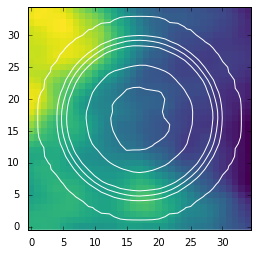

In [210]:
plt.imshow(obs_cube.moment0().data, interpolation='none', cmap='viridis')
plt.contour(model_cube.moment0().data, np.linspace(0.01, np.nanmax(model_cube.moment0().data), 5),
            colors='white')

### Make a mask out of Model Cube with True where Model_cube > 0.

In [211]:
shell_mask = model_cube > 0.00001*u.dimensionless_unscaled
#print(obs_cube.wcs, model_cube.wcs)
#obs_cube_masked = obs_cube.with_mask(shell_mask)

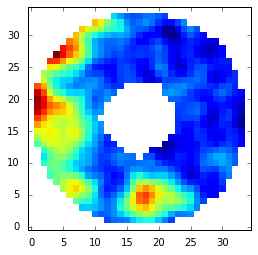

In [212]:
obs_cube_masked = obs_cube.with_mask(shell_mask)
obs_array_masked = obs_cube_masked.filled_data[:,:,:]
plt.imshow(obs_cube_masked[40].data, interpolation='none')

## IT WORKED!